## Kaggle Credit Card Anti Fraud Implementation 
>1. Project introduction and data source：[Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)  
>2. Machine Learning Category：**Supervised binary classification problem** OR **Unsupervised anamoly detection problem**    
>3. Supervised learning scheme 1：Perform the classification task using [BalancedRandomForestClassifier](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedRandomForestClassifier.html#imblearn.ensemble.BalancedRandomForestClassifier), [RusBosstClassifier](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedRandomForestClassifier.html#imblearn.ensemble.BalancedRandomForestClassifier) and [LGBMClassifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html?highlight=classifier)  
>4. Supervised learning scheme 2: Also, we can first apply some resampling methods such as [Smotetomek](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTETomek.html?highlight=smotet#imblearn.combine.SMOTETomek) and [Smoteenn](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTEENN.html) to make the unbalanced datasets balanced, then we can use the normal classification algorithms as usual  
>4. Unsupervised learning scheme：Perform the anamoly detection task using [Isolation Forest](https://pyod.readthedocs.io/en/latest/pyod.models.html?highlight=iforest#pyod.models.iforest.IForest) OR [Autoencoder network](https://pyod.readthedocs.io/en/latest/pyod.models.html?highlight=iforest#module-pyod.models.auto_encoder)  
>5. In this notebook, we are going to implement the [Exploratory data analysis: EDA](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) and some preprocessing  
>5. keywords: [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/index.html),[pytorch](https://pytorch.org/), [skorch](https://skorch.readthedocs.io/en/stable/user/quickstart.html), [tune-sklearn](https://github.com/ray-project/tune-sklearn) from ray.tune, [dask ml](https://ml.dask.org/), [sklearn](https://scikit-learn.org/stable/), [microsoft nni](https://nni.readthedocs.io/en/latest/Overview.html), [hyperopt](https://github.com/hyperopt/hyperopt)  
>6. About feature selection: [Borutapy](https://github.com/scikit-learn-contrib/boruta_py) and [GradientFeatureSelector](https://nni.readthedocs.io/en/latest/FeatureEngineering/GradientFeatureSelector.html)  

## Tricks to deal with the imbalance  
>1. [Oversampling and Undersampling](https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb), or the combination of them [Smotetomek](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTETomek.html?highlight=smotet#imblearn.combine.SMOTETomek) and [Smoteenn](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTEENN.html)  
>2. Evaluation metrics: f1_score, [geometric_mean_score](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.metrics.geometric_mean_score.html#imblearn.metrics.geometric_mean_score)  
>* [Ref1:Dealing With Class Imbalanced Datasets For Classification](https://towardsdatascience.com/dealing-with-class-imbalanced-datasets-for-classification-2cc6fad99fd9)    
>* [Ref2:机器学习之类别不平衡问题 (3) —— 采样方法](https://www.cnblogs.com/massquantity/p/9382710.html)  
>* [Ref3:机器学习中的非均衡问题(imbalanced data)和应对方法](https://zhuanlan.zhihu.com/p/38687978)  
>* [Ref4:机器学习：如何解决机器学习中数据不平衡问题](https://www.jianshu.com/p/be343414dd24)


### I. Load the data and do some preliminary exploration on it

In [1]:
# Load the most widely used libraries for data processing
import numpy as np
import pandas as pd
import torch

In [2]:
# Read the data of csv format as pandas dataframe
data_original = pd.read_csv('creditcard.csv')

In [3]:
type(data_original)

pandas.core.frame.DataFrame

In [4]:
# Data overview
data_original.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Show the data scale, dtype of each feature and show whether there exist missing values under each feature
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Based on the info above, we know that:  
>1. The dtype of all features are numerical thus we don't have to perform any one hot encodinng which is necessary for categorical features  
>2. There are no missing values under each feature thus we don't have to process the missing values like dropping or imputation

In [6]:
# Recheck the number of missing values under each feature
data_original.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
# Check the total number of missing values in the dataset
data_original.isnull().sum().sum()

0

Based on the result above, it's confirmed that there are no missing values in the data thus we won't perform any missing value processing

In [8]:
# Count distinct observations under each column including target column
data_original.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

In [9]:
# Count unique values under target, i.e., see how many classes in the target column
data_original['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

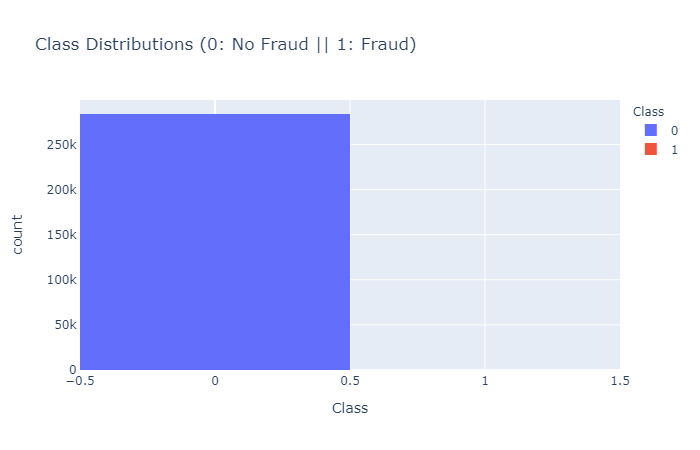

In [34]:
# Visualize the class distribution using plotly
import plotly.express as px
fig = px.histogram(data_original,x='Class',color='Class',title='Class Distributions (0: No Fraud || 1: Fraud)')
# fig.show()
fig.show('png')

In [11]:
# Show the percentage of each class in the data
data_original['Class'].value_counts(normalize = True)*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

In [12]:
# Show some statistics of the dataset
data_original.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Summary of the data exploration:  
1. There are in total 284807 samples in the dataset  
2. Data contains 30 feature columns and 1 target column 
3. There are no missing values under each feature column and target column so no need for missing value processing
4. All the features are continuous numerical features without categorical features,so no need for one-hot encoding
5. The class distribution is clearly quite imbalanced, with no-fraud occupying 99.83% and fraud occupying only 0.17%

### II. Feature-label split and train-test split  
>To avoid the data leakage，before any data preprocessing, perform the train-test split first  
>[Reference1：Normalize data before or after split of training and testing data?](https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data)  
>[Reference2：Onehotencoding before or after split of training and testing data?](https://stackoverflow.com/questions/55525195/do-i-have-to-do-one-hot-encoding-separately-for-train-and-test-dataset)  
>[Reference3：Imputation before or after train test spliting](https://stats.stackexchange.com/questions/95083/imputation-before-or-after-splitting-into-train-and-test)

In [13]:
# Feature-label split
# we think the 'time' feature is not that influential so we just delete it
X = data_original.iloc[:,1:-1]
y = data_original['Class']

In [14]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [15]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [16]:
# Train-test split with 75% data split as train set and 25% as test set
# Attention，here we'll use the stratified sampling for the dataset split to confirm that the class distribution keeps same or  similar before and after splitting
# Besides，if we already know certaian feature is crucial beforeband, we can also perform the stratified sampling based on that feature instead of the class
# Reference1：https://medium.com/@411.codebrain/train-test-split-vs-stratifiedshufflesplit-374c3dbdcc36
# Reference2：https://zhuanlan.zhihu.com/p/49991313
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42) 

Calculate class weights  
>1. For binary classification problems, some models may require a class_weight of dict format: {0:0.2, 1:0.6}, while the other models may require a scale_pos_weight = count(negative examples)/count(Positive examples)  
>2. For multiclassification problems, some models require a dict class_weieght while others may require a tensor  
>3. To calculate the class weights for each class, one way is to do it following the rules :  
Weight of class C is the size of largest class divided by the size of class C  
>4. Another more convenient way is to utilize the sklearn __compute_class_weight function__, however the result of this function is an array not a dict, thus we still need to transfer it to a dict format using dict(enumerate())


In [17]:
# As this is a imbalanced problem ,we need calculate the weights of each class for the following pytorch training
# https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html
# Important : https://datascience.stackexchange.com/questions/48369/what-loss-function-to-use-for-imbalanced-classes-using-pytorch
# https://blog.csdn.net/oJiMoDeYe12345/article/details/80196376
weight_torch = torch.tensor([1,577.88])

In [18]:
# the second way which may be more convenient to calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)

In [19]:
type(class_weights)

numpy.ndarray

In [20]:
cw = dict(enumerate(class_weights))
cw

{0: 0.5008652385150725, 1: 289.43766937669375}

### III.Feature Scaling  
>1. Why should we perform the feature scaling?  
*After feature scaling，the magnitude of each feature will be similar which help accelerate gradient descent converge*  
*[Ref1:Feature Scaling with scikit-learn](https://benalexkeen.com/feature-scaling-with-scikit-learn/)*  
*[Ref2:为什么 feature scaling 会使 gradient descent 的收敛更好?](https://www.zhihu.com/question/37129350)*  
*[Ref3:机器学习（一）- feature scaling](https://blog.csdn.net/mike112223/article/details/74923096)*  
*[Ref4:sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) *  
*[Ref5:特征缩放的几种方法](https://www.cnblogs.com/HuZihu/p/9761161.html) *  
>2. *We only perform the feature scaling on those continuous numeric features，not on any discrete categorical features*  
*[Ref1:Should you ever standardise binary variables?](https://stats.stackexchange.com/questions/59392/should-you-ever-standardise-binary-variables)*  
*[Ref2:Dummy variables, is it necessary to standardize them?
](https://stackoverflow.com/questions/50557129/dummy-variables-is-necessary-to-standardize-them)*  
>3. *Three most widely used feature scaling methods: min-max scaling，standardization and RobustScaler:*  
   *- min-max scaling(normalization):*  
   $ X_{minmax} = \frac{X - X_{min}}{X_{max} - X_{min}} $  
   *- standardization(Z-score):*  
   $ X_{std} = \frac{X - \mu }{\sigma } $  *($\mu$ is the mean, $\sigma$ is the standard deviation)*  
   *- robustscaler:*  
   $ X_{rb} = \frac{X - Q_1(x) }{Q_3(x) - Q_1(x)} $ *($Q_1$ is the first Quartile， $Q_3$ is the third Quartile)*  
   [Ref1:Feature Scaling with scikit-learn](https://benalexkeen.com/feature-scaling-with-scikit-learn/) 
>4. *Other feature scaling methods: PowerTransformer and QuantileTransformer*
>5. *[Ref1：Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py) *  
*[Ref2：Which advantages does MinMax scaling have over a standard scaling using the mean and the standard deviation?](https://www.quora.com/Which-advantages-does-MinMax-scaling-have-over-a-standard-scaling-using-the-mean-and-the-standard-deviation) *  
*[Ref3：How to Identify Outliers in your Data？](https://machinelearningmastery.com/how-to-identify-outliers-in-your-data/) *  
*[Ref4：How to Make Your Machine Learning Models Robust to Outliers？](https://www.kdnuggets.com/2018/08/make-machine-learning-models-robust-outliers.html) *      
>6. *__Attention__: We need first split the train and test set, then perform the feature scaling on train set, then perform the feature scaling on test set, with the scaler values calculated on train set (not test set).*  
*[Ref1：Difference between preprocessing train and test set before and after splitting](https://stats.stackexchange.com/questions/267012/difference-between-preprocessing-train-and-test-set-before-and-after-splitting) *




In [21]:
# Here we use the Standardization(Z-score) method which has been widely used for NN feature scaling
from sklearn.preprocessing import StandardScaler

scaler_std = StandardScaler()  
X_train_copy = X_train.copy(deep=True)
X_train_std = scaler_std.fit_transform(X_train_copy)

In [22]:
type(X_train_std)

numpy.ndarray

In [23]:
type(y_train)

pandas.core.series.Series

### IV. Feature Selection  
>* Essence of feature selection：drop those redundant or irrelevant features, perform the dimensionality reduction on the orignal feature space 
>* possible benefit of feature selection：improve the model's predictability, avoid overfitting, improve the training speed  
>* Location of feature selection: generally it should be done [after the feature selection](https://stackoverflow.com/questions/46062679/right-order-of-doing-feature-selection-pca-and-normalization)  
>* Feature selection methods: generally, three categories (Filter)，(Wrapper) and (Embedded)  
>>* Filter method doesn't rely on any ML model. With this method, we don't have to train some model to calculate the feature importances, so it's model-independent. Some widely used methods in this category are:  
Welch's t-Test, Fisher score, Chi-Squared test, Relief-based, CFS(Correlation-based feature selection),  
FCBF(Fast correlation-based filter)等等。
>>* Wrapper method needs a certain model to train and then based on the results, it gives the feature importances. The problem is, there are no guildlines on which model to choose to train for the feature selection, so it's model dependent. To solve this model uncertainty, there are two possible ways that can be tried. First, use the voting method, which means we can first try several models for feature selection and finally based on the voting rules to confirm which features should be left. [Second, keep the model for feature selection and the model for the final training consistent](https://zhuanlan.zhihu.com/p/74198735). Possible wrapper methods：Recursive Feature Elimination(RFE), Simulated Annealing(SA), and Genetic Algorithm(GA) etc. Among them，[genetic algorithm can confirm to get the global optimum](http://www.feat.engineering/genetic-algorithms.html),but it's very time-consuming，low efficient，and is advised to try only when the computing resource is quite sufficient and you don't have to catch the deadline.  
>>* Embedded method，regularization, L1-Lasso，L2-Ridge and Elastic Net.
>* [Ref1:Overview of feature selection methods](https://towardsdatascience.com/overview-of-feature-selection-methods-a2d115c7a8f7)  
[Ref2:Machine Learning Explained: Regularization](http://enhancedatascience.com/2017/07/04/machine-learning-explained-regularization/)  
[Ref3:机器学习（六）：特征选择方法—Filter,Wrapper,Embedded](https://zhuanlan.zhihu.com/p/120924870)  
[Ref4:基于 Jupyter 的特征工程手册：特征选择（四）](https://zhuanlan.zhihu.com/p/138758083)  
[Ref5：特征选择，经典三刀](https://zhuanlan.zhihu.com/p/24635014)  
[Ref6：特征工程笔记](https://www.jianshu.com/p/03284dd5e0bf)  

>* Two promising feature selection methods:  
[Borutapy](https://github.com/scikit-learn-contrib/boruta_py) and [GradientFeatureSelector](https://nni.readthedocs.io/en/latest/FeatureEngineering/GradientFeatureSelector.html)：  
>>* When using BorutaPy, in the wrapper we should select the RandomForest or BalancedRandomForest for feature selection. Some other models like xgboost and lightgbm are not compatible.  
>* [Boruta Ref1：Select Important Variables using Boruta Algorithm](https://www.datasciencecentral.com/profiles/blogs/select-important-variables-using-boruta-algorithm)  
>* [Boruta Ref2：Boruta explained exactly how you wished someone explained to you](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a)  
>* [Boruta Ref3：Feature selection? You are probably doing it wrong](https://towardsdatascience.com/feature-selection-you-are-probably-doing-it-wrong-985679b41456)  
>* [Boruta Ref4: Boruta-xgboost](https://github.com/chasedehan/BoostARoota)  


In [24]:
from boruta import BorutaPy
from imblearn.ensemble import BalancedRandomForestClassifier


In [25]:
# Return the feature names of the dataset
# https://stackoverflow.com/questions/19482970/get-list-from-pandas-dataframe-column-headers
Columns = X_train.columns.to_numpy()
Columns

array(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype=object)

In [26]:
# max_depth value is advised to be set within the range randint [3,7] by the author of the botutapy
# the other hyparams just keep the default setting, no tuning here
brf = BalancedRandomForestClassifier(n_jobs=-1, class_weight = cw, max_depth=7,random_state=42)
feat_selector_brf = BorutaPy(brf, n_estimators='auto', verbose=2, random_state=42)

In [27]:
feat_selector_brf.fit(X_train_std, y_train.to_numpy())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	20
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	20
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	20
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	20
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	21
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	21
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	21
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	21
Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	21
I

BorutaPy(estimator=BalancedRandomForestClassifier(class_weight={0: 0.5008652385150725,
                                                                1: 289.43766937669375},
                                                  max_depth=7, n_estimators=57,
                                                  n_jobs=-1,
                                                  random_state=RandomState(MT19937) at 0x20F07464D40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x20F07464D40, verbose=2)

In [28]:
# After feature selection by Borutapy, the original features will be categorized as three classes: (1) those that are confirmed useful for model prediction and so kept (2) those that are confirmed not useful and so deleted (3) those that Boruta cannot confirm wether useful or not so cannot decide whether to keep or delete and this decision should be made by users, in short, those that are in doubt
# support_ attribute contains the first class while support_weak_ contains the third class
confirmed_brf = feat_selector_brf.support_
features_confirmed_brf = Columns[confirmed_brf]
features_confirmed_brf

array(['V1', 'V3', 'V4', 'V11', 'V12', 'V14', 'V24'], dtype=object)

So, Borutapy think the features \['V1', 'V3', 'V4', 'V11', 'V12', 'V14', 'V24'\] are useful and will keep them.

In [29]:
tentative_brf = feat_selector_brf.support_weak_
features_tentative_brf = Columns[tentative_brf]
features_tentative_brf

array(['V9'], dtype=object)

Similarly, Borutapy think whether to keep or delete the feature \['V9'\] is tentative and needs user's decision

In [30]:
# features_filtered_narrow only keep those confirmed features by Borutapy
X_train_filtered_brf_narrow = feat_selector_brf.transform(X_train_std)
X_train_filtered_brf_narrow.shape

(213605, 7)

In [31]:
# features_filtered_broad contains both the confirmed and tentative features,just set weak = True
X_train_filtered_brf_broad = feat_selector_brf.transform(X_train_std,weak = True)
X_train_filtered_brf_broad.shape

(213605, 8)